# MAST Plasma Current

Infer plasma current from CCFE's Mega Ampere Spherical Tokamak using discrete magnetic diagnostic data.

> **Note:** The dataset files for this challenge should be available in the `fair_mast_data/plasma_current` directory.

## Overview
This notebook addresses the first of three Data Science challenges for the ITER International School 2024.

**Challenge Goal:** Reconstruct plasma current time-series waveforms from the Mega Ampere Spherical Tokamak (MAST) using magnetic field measurements.

The open-source MAST Data Catalog provides all data for this challenge. Credit to Samuel Jackson, Nathan Cummings, Saiful Khan, and the MAST community for creating this FAIR dataset.

## Description
Tokamaks measure plasma current with high precision. In this challenge, you must reconstruct plasma current waveforms by applying machine learning to magnetic diagnostic signals.

We've removed information about the location, orientation, and calibration of diagnostic measurements to prevent using traditional inference techniques.

This challenge presents a labeled regression problem. Your model must transform one-dimensional signals into accurate target waveforms.

The image below shows signals and targets from the first shot in the training dataset: 

![MAST Plasma Signals and Targets](../media/images/plasma_current.png)

## Dataset Information

The `./fair_mast_data/plasma_current` directory contains data files for the MAST Plasma Current challenge.

### Available Files
Both train and test files use a simple CSV format with a single header.

- `train.csv` - Training dataset
- `test.csv` - Test dataset

### Data Structure
- `index` - Unique identifier for each sample
- `time` - Measurement time in seconds
- `XMA_CCBV04:XMA_CCBV36` - Magnetic measurements from the center_column group in volts
- `XMA_OBR03:XMA_OBR17.1` - Magnetic measurements from the outer_discrete group in volts
- `plasma_current` - Target plasma current in kiloamperes (kA)

## Example

The code below demonstrates how to prepare a competition submission. This basic approach provides a starting point that you'll need to improve to achieve competitive scores.

First, we'll import the necessary libraries for data processing, visualization, and machine learning. Python libraries are organized at the top in three groups: standard library, third-party packages, and local modules.

## Installation Instructions

### Local Installation

1. Clone the repository

   ```bash
   git clone https://github.com/Simon-McIntosh/data-science-challenges.git
   ```

2. Navigate to the project directory

   ```bash
   cd data-science-challenges
   ```

3. Install [uv](https://docs.astral.sh/uv/getting-started/installation/#standalone-installer) if you don't have it already

   ```bash
   pipx install uv
   ```

4. Create a virtual environment and install dependencies using uv

   ```bash
   uv venv
   uv pip install -e .
   ```

5. Activate the virtual environment

   ```bash
   # On Windows
   .venv\Scripts\activate

   # On Unix or MacOS
   source .venv/bin/activate
   ```

### Google Colab Setup

If you're using Google Colab to run this notebook, you'll need to install the project package first. The recommended installation method uses the `uv` package installer for faster dependency resolution:

```bash
!pip install uv
!uv pip install git+https://github.com/Simon-McIntosh/data-science-challenges.git
```

You may also install directly with pip, though installation might be slower:

```bash
!pip install git+https://github.com/Simon-McIntosh/data-science-challenges.git
```

After installation, you may need to restart your runtime for all changes to take effect. You can do this by clicking on the "Runtime" menu and selecting "Restart runtime".

In [27]:
# Standard library imports
import importlib.resources
import pathlib

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.linear_model
import sklearn.metrics
import sklearn.model_selection
import sklearn.pipeline

### Data Loading
First, we locate the data files. The `train.csv` and `test.csv` files are stored in the `fair_mast_data/plasma_current` directory. We use the `pathlib` library to find these files.

In [28]:
pkg_path = resources.files("data_science_challenges")
data_path = pkg_path / "fair_mast_data" / "plasma_current"

print(list(pathlib.Path(data_path).glob("*.csv")))

[WindowsPath('c:/Users/mcintos/Code/data_science_challenges/.venv/Lib/site-packages/data_science_challenges/fair_mast_data/plasma_current/linear_regression.csv'), WindowsPath('c:/Users/mcintos/Code/data_science_challenges/.venv/Lib/site-packages/data_science_challenges/fair_mast_data/plasma_current/test.csv'), WindowsPath('c:/Users/mcintos/Code/data_science_challenges/.venv/Lib/site-packages/data_science_challenges/fair_mast_data/plasma_current/train.csv')]


In [29]:
# Load the data into train and test DataFrames using the stored data_path
train = pd.read_csv(data_path / 'train.csv')
test = pd.read_csv(data_path / 'test.csv')

# Print the first few rows of the train DataFrame
print(train.head())


   index     time  XMA_CCBV04  XMA_CCBV12  XMA_CCBV20  XMA_CCBV28  XMA_CCBV36  \
0      0 -0.06560   -0.126953   -0.024414   -0.014648   -0.029297   -0.268555   
1      1 -0.06535   -0.129395   -0.024414   -0.017090   -0.031738   -0.273438   
2      2 -0.06510   -0.129395   -0.024414   -0.017090   -0.034180   -0.275879   
3      3 -0.06485   -0.131836   -0.024414   -0.017090   -0.031738   -0.278320   
4      4 -0.06460   -0.131836   -0.024414   -0.017090   -0.029297   -0.278320   

   XMA_OBR03  XMA_OBR03.1  XMA_OBR06  XMA_OBR06.1  XMA_OBR14  XMA_OBR14.1  \
0  -0.002441    -0.002441  -0.031738    -0.031738  -0.019531    -0.019531   
1  -0.002441    -0.002441  -0.031738    -0.031738  -0.019531    -0.019531   
2  -0.002441    -0.002441  -0.031738    -0.031738  -0.019531    -0.019531   
3  -0.002441    -0.002441  -0.031738    -0.031738  -0.019531    -0.019531   
4  -0.002441    -0.002441  -0.029297    -0.029297  -0.019531    -0.019531   

   XMA_OBR17  XMA_OBR17.1  shot_index  plasma_curr

### Model Pipeline
Create a scikit-learn pipeline to process training and test data consistently. This example uses a minimal pipeline setup.

In [30]:
pipe = sklearn.pipeline.make_pipeline(
    sklearn.linear_model.LinearRegression(),
)

### Data Preparation
We divide the training data into features (X) and target (y), then split into training and validation sets. This example uses all signal columns as features. A thorough understanding of your data before this step significantly improves results.

In [31]:
X, y = train.drop("plasma_current", axis=1), train.plasma_current
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    test_size=0.3,
    shuffle=True,
    random_state=3,
)

### Model Training and Evaluation

First, we fit the model to the training set and generate predictions for the validation set.

In [32]:
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

#### Understanding Model Evaluation Metrics

We evaluate model performance using multiple metrics. While the challenge uses only Mean Absolute Percentage Error (MAPE) for scoring, additional metrics provide valuable insights during development.

**Mean Absolute Percentage Error (MAPE)**

MAPE measures the average percentage difference between predicted and actual values. Mathematically, it's calculated as:

$MAPE = \frac{100\%}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right|$

Where:
- $y_i$ represents the true plasma current value
- $\hat{y}_i$ represents the predicted plasma current value
- $n$ is the number of predictions being evaluated

**Why use MAPE for this challenge?**
- **Scale-independence**: MAPE expresses error as a percentage, making it useful for comparing performance across different datasets or plasma current magnitudes
- **Interpretability**: The percentage format is intuitive for understanding prediction accuracy
- **Competition metric**: This is the primary scoring metric for the challenge

**Mean Absolute Error (MAE)**

MAE measures the average magnitude of errors between predicted and actual values, without considering their direction. 

$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

**Benefits of MAE:**
- **Same units**: Expressed in kiloamperes (kA), making it directly interpretable in the physical context
- **Robustness**: Less sensitive to outliers than squared error metrics
- **Direct interpretation**: Tells us the average absolute deviation in kA between predictions and actual values

In [33]:
# Calculate Mean Absolute Percentage Error (MAPE)
# Lower values indicate better model performance (0% is perfect)
mape = sklearn.metrics.mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE {mape:1.3f} (lower is better)")

# Calculate Mean Absolute Error (MAE) in kiloamperes
# This is more intuitive as it's in the same units as plasma current
mae = sklearn.metrics.mean_absolute_error(y_test, y_pred)
print(f"MAE {mae:1.3f} kA (lower is better)")

MAPE 5.023 (lower is better)
MAE 9.959 kA (lower is better)


### Making Predictions and Generating Submissions

After validating our model performance, we can generate predictions for the test dataset and prepare a submission file. The Plasma Current challenge requires a CSV file with "index" and "plasma_current" headers followed by predictions.

In [34]:
# Make predictions for the test dataset
predictions = pipe.predict(test)

# Create and save submission file
submission = pd.DataFrame(predictions, columns=["plasma_current"])
submission.index.name = "index"

# Save the submission file using the stored data_path
submission.to_csv(data_path / "linear_regression.csv")

### Results Visualization

Visualizing predictions against validation data helps evaluate performance. Since the competition includes multiple plasma pulses, displaying individual waveforms improves interpretation. We first reorder the dataset that was shuffled during splitting.

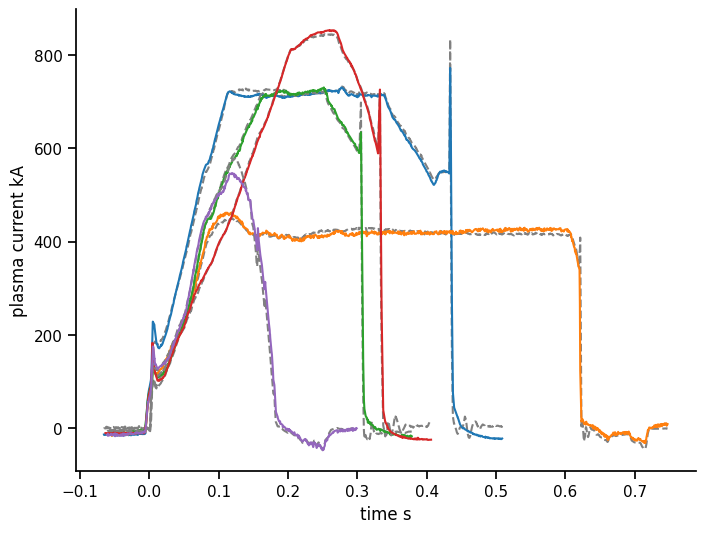

In [35]:
sns.set_context("notebook")
axes = plt.subplots(figsize=(8, 6))[1]

sort_index = np.argsort(X_test.time)
_X_test = X_test.iloc[sort_index]
_y_test = y_test.iloc[sort_index]
for shot_index in np.unique(X_train.shot_index):
    index = _X_test.shot_index == shot_index
    axes.plot(_X_test.loc[index, "time"], _y_test.loc[index], "--", color="gray")
    axes.plot(_X_test.loc[index, "time"], pipe.predict(_X_test)[index])
axes.set_xlabel("time s")
axes.set_ylabel("plasma current kA")
sns.despine()

### Model Assessment and Next Steps

The plot compares actual plasma current (gray dashed lines) with model predictions (colored lines). When evaluating your model, consider these key questions:

1. Do the predictions match your expectations?
2. How accurately does the model fit the data?
3. Is there data leakage between training and validation sets?
4. What methods could fix potential leakage issues?

For improving model performance, consider:
- Using more sophisticated models beyond linear regression
- Implementing feature engineering to enhance signal data
- Applying appropriate preprocessing techniques
- Tuning model hyperparameters

Your final ranking depends on your score on the private leaderboard section, which uses a hidden evaluation dataset.